In [166]:
import random
import copy
from ase import io as aio
from ase import build
import numpy as np
import abtem
import matplotlib.pyplot as plt
import ase.visualize.plot as viz
from sim_stem import simulate_stem, preview_stem_result
from utils import tk_popover

In [167]:
abtem.config.set({"device":              "cpu",  # Configure abTEM to run on the GPU
                  "dask.lazy":           True,  # Setting to False can be useful for debugging
                  "dask.chunk-size":     "128 MB",  # 128 MB is the standard L3 cache size (per core)
                  "dask.chunk-size-gpu": "512 MB",  # Remember to leave space for overhead
                  "scheduler":           "threads",  # Threads or processes
                  "num_workers":         1  # Number of threads/processes to use for simulation (set to 1 for gpu)
                  })

<Axes: >

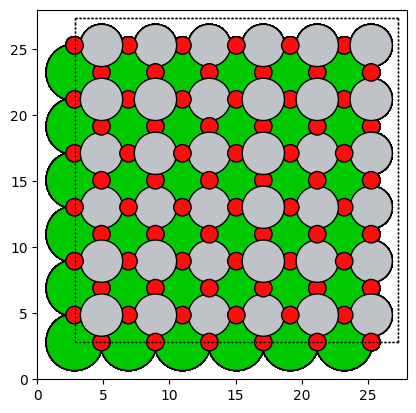

In [168]:
%matplotlib inline
uc = aio.read(tk_popover())

thickness: float = 200  # Angstrom
reps: int = 6

c = np.linalg.norm(build.surface(uc, indices=(1, 0, 0), layers=1, periodic=True).cell[2])
surf = build.surface(uc, indices=(1, 0, 0), layers=int(thickness//c + 1), periodic=True)
slab = abtem.orthogonalize_cell(surf)
slab *= (reps, reps, 1)
viz.plot_atoms(slab)

In [169]:
sigs = {"Ba": 0.0757,
        "Ti": 0.0893,
        "O":  0.0810}

num_configs = 50
fps = abtem.FrozenPhonons(slab,
                          num_configs=num_configs,
                          sigmas=sigs,
                          ensemble_mean=False)  # Don't compute the mean, we want to see all of the configs

potential = abtem.Potential(fps,
                            sampling=0.04,
                            projection="infinite",
                            parametrization="kirkland",
                            slice_thickness=2)
detector = abtem.detectors.AnnularDetector(70, 200)

[########################################] | 100% Completed | 108.29 ms


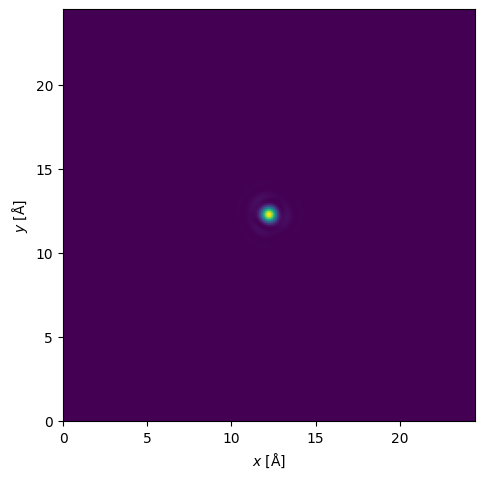

In [170]:
aberrations = {"C10":   22,     # Defocus (C1)
               "C12":   7,      # 2-fold stig (A1)
               "phi12": 2.71,   # 2-fold stig angle
               "C21":   335,    # Coma (B2)
               "phi21": 2.67,   # Coma angle
               "C23":   480,    # 3-fold stig (A2)
               "phi23": 0,      # 3-fold stig angle
               "C30":   -5200,  # Spherical aber (C3 / CS)
               "C32":   7600,   # "Star" aber (S3)
               "phi32": -0.37,  # Star aber angle
               "C34":   3900,   # 4-fold stig (A3)
               "phi34": -1.71,  # 4-fold stig angle
               "C41":   8.4e4,  # 4th order coma (B4)
               "phi41": -0.24,  # 4th order coma angle
               "C43":   1.4e5,  # Three-lobe aber (D4)
               "phi43": 1.40,   # Three-lobe aber angle
               "C45":   1.1e4,  # 5-fold stig (A4)
               "phi45": 1.40,   # 5-fold stig angle
               "C50":   -8e6,   # 5th order spherical aber (C5)
               "C52":   9.7e5,  # 5th order star aber (S5)
               "phi52": 2.04,   # 5th order star aber angle
               "C54":   3.2e5,  # Rosette aber (R5)
               "phi54": -2.09,  # Rosette aber angle
               "C56":   2.8e6,  # 6-fold stig (A5)
               "phi56": 0.98    # 6-fold stig angle
               }

abtem.Probe(semiangle_cutoff=17.9, energy=200e3, aberrations=aberrations).match_grid(potential).show()

scangrid = abtem.scan.GridScan((0, 0), (1/6, 1/6), fractional=True, potential=potential)

Simulating...
[########################################] | 100% Completed | 21m 59ss


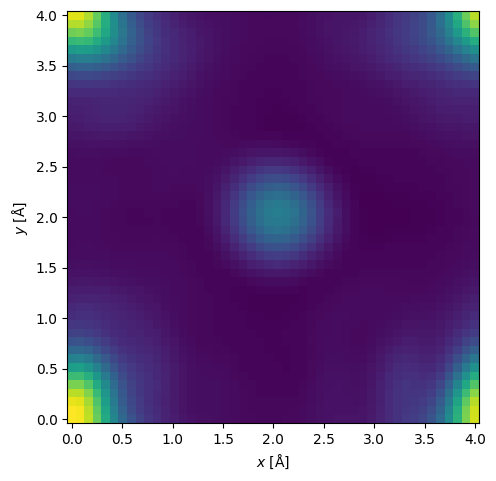

In [171]:
result = simulate_stem(potential=potential, detectors=detector, convergence=17.9, aberrations=aberrations, scan=scangrid, eager=True)
# Maybe I should pickle the result?
preview_stem_result(result)

In [172]:
# By eye, slicing [2:-1, 2:-1] gets us just the central peak
# Before interpolating, central peak intensity is almost all in 3x3 region around peak
# The _right_ way to do this is to actually fit a gaussian, but that is probably excessive in this case
integrals = []
for res in result:
    max_loc = np.where(res.array==np.max(res.array[2:-1, 2:-1]))
    max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with
    integrals.append(np.sum(res.array[max_loc[0]-1:max_loc[0]+1, max_loc[1]-1:max_loc[1]+1]))

C:\Users\charles\AppData\Local\Temp\ipykernel_71296\1540427849.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_loc = (int(max_loc[0]), int(max_loc[1]))  # Return value of where is annoying to work with


In [173]:
# In principle the order should not matter, so we want to repeat this analysis for a bunch of random permutations of the configs
permutes = []
for i in range(100):
    permute = copy.copy(integrals)
    random.shuffle(permute)
    permutes.append(permute)

In [174]:
permuted_means = []
for p in permutes:
    means = np.zeros(num_configs)
    for i in range(num_configs):
        means[i] = (sum(p[:i+1])) / len(p[:i+1])
    permuted_means.append(means)

In [175]:
end_val = np.mean([m[-1] for m in permuted_means])

stdevs = []
for i in range(num_configs):
    stdevs.append(np.std([m[i] for m in permuted_means]))

conv_thresh = 0.01
sigmas = 1
for i, s in reversed(list(enumerate(stdevs))):
    if end_val+(sigmas*s) > end_val*(1+conv_thresh): 
        conv_idx = i
        break
if "conv_idx" not in locals():  # Failure to converge
    conv_idx = num_configs

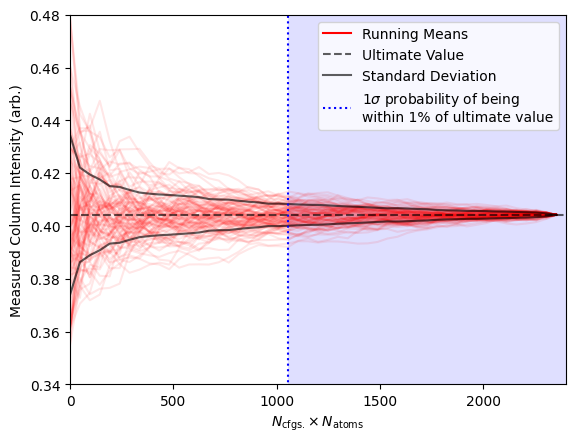

In [176]:
plt.axvspan(list(range(num_configs))[conv_idx]*(thickness//c), num_configs*(thickness//c), facecolor="#0000FF20")

xs = range(num_configs)*(thickness//c)

plt.plot(0, 0, "#FF0000FF", label="Running Means")  # Just to get the patch on legend w/o reduced alpha
for m in permuted_means:
    plt.plot(xs, m, "#FF000018")

plt.hlines(end_val, 0, num_configs*(thickness//c), "#000000A0", "--", label="Ultimate Value")
plt.plot(xs, [end_val+s for s in stdevs], "#000000A0", label="Standard Deviation")
plt.plot(xs, [end_val-s for s in stdevs], "#000000A0")

plt.vlines(list(range(num_configs))[conv_idx]*(thickness//c), 0.3, 0.5, "b", ":", label=f"{sigmas}"
                                                                                        +r"$\sigma$ probability of being "
                                                                                        +"\nwithin "
                                                                                        +f"{100*conv_thresh:.0f}% of ultimate value")

plt.xlim(0, num_configs*(thickness//c))
plt.ylim(0.34, 0.48)
plt.xlabel(r"$N_{\text{cfgs.}} \times N_{\text{atoms}}$")
plt.ylabel(r"Measured Column Intensity (arb.)")
plt.legend()
plt.show()